# Derive the Dynamics and Sensor Model

## Derive Dynamics Model

Import all packages used to derive the equations of motion of the system

In [1]:
import sympy as sym
import numpy as np
sym.init_printing()

In [2]:
# Get the gravity in m/s^2
from ae353_quadrotor import get_gravity
planet = "Earth"
grav = get_gravity(planet, verbose=True)

Define all the system constants (system parameters)

In [3]:
#Mass, moments of inertia, and other drone constants
mass = 0.964    # The mass of the quadrotor in kg
Ixx = 0.002239  # The moment of inertia of the quadrotor in 
Iyy = 0.002239  # The mass of the quadrotor in kg
Izz = 0.001391  # The mass of the quadrotor in kg
lxy = 0.1055    # The distance between the rotors and center of mass
k = 0.15       # The lift constant
b = 0.092       # The drag coefficient
#can also be expressed symbolically
#mass,Ixx,Iyy,Izz,lxy,k,b = sym.symbols("mass,Ixx,Iyy,Izz,l,k,b")

Generate the symbols that define the state of the quadrotor. Also, create the rotation matrices that define the orientation of the quadrotor in the world coordinate system.

In [4]:
# Define position
px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

# Define velocity
vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')
n = sym.Matrix([[phi],
                [theta],
                [psi]])


# Define angular velocities
wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z') # same as the angle dots
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

# Define roll, pitch, and yaw rotation matrices that describe the drone's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T
R_ofB_inW

⎡cos(ψ)⋅cos(θ)  sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)  sin(φ)⋅sin(ψ) + sin(θ)⋅c
⎢                                                                             
⎢sin(ψ)⋅cos(θ)  sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)  -sin(φ)⋅cos(ψ) + sin(ψ)⋅
⎢                                                                             
⎣   -sin(θ)                sin(φ)⋅cos(θ)                          cos(φ)⋅cos(θ

os(φ)⋅cos(ψ) ⎤
             ⎥
sin(θ)⋅cos(φ)⎥
             ⎥
)            ⎦

Calculate the roll, pitch, and yaw rates as a function of the orientation and body-fixed angular rates.

In [5]:
#**Inertial Frame**
# Define the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Invert the transformation to get a matrix that takes body-fixed angular rates to 
# roll, pitch, and yaw rates
M_inv = sym.simplify(M.inv())

# Convert the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = sym.simplify(M_inv@w_inB) #ndot as described by the paper (4)
print("Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:")
sym.N(rpy_dot,3)

Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:


⎡ωₓ + ω_y⋅sin(φ)⋅tan(θ) + ω_z⋅cos(φ)⋅tan(θ)⎤
⎢                                          ⎥
⎢         ω_y⋅cos(φ) - ω_z⋅sin(φ)          ⎥
⎢                                          ⎥
⎢         ω_y⋅sin(φ) + ω_z⋅cos(φ)          ⎥
⎢         ───────────────────────          ⎥
⎣                  cos(θ)                  ⎦

Next we assemble the moment of inertia tensor.

In [6]:
# Assemble the moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

Generate the symbols that define the input to the system. Also sum the together to get the net torque vector and force vector.

In [7]:
# Define inputs
taux_inB, tauy_inB, tauz_inB, fz_inB,w1,w2,w3,w4 = sym.symbols('tau_x, tau_y, tau_z, f_z,w1,w2,w3,w4')
#Fz is the total thrust T
fz_inB = k* (w1**2+w2**2+w3**2+w4**2)

taux_inB = lxy*k*(-w2**2+w4**2)
tauy_inB = lxy*k*(-w1**2+w3**2)
tauz_inB = b*(w1**2+w2**2+w3**2+w4**2) 


# Get the net torque vector
tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

# Get the gravity force and convert to body coordiantes
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Get the net force vector
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)
tau_inB


⎡                     2              2        ⎤
⎢        - 0.015825⋅w₂  + 0.015825⋅w₄         ⎥
⎢                                             ⎥
⎢                     2              2        ⎥
⎢        - 0.015825⋅w₁  + 0.015825⋅w₃         ⎥
⎢                                             ⎥
⎢        2           2           2           2⎥
⎣0.092⋅w₁  + 0.092⋅w₂  + 0.092⋅w₃  + 0.092⋅w₄ ⎦

Convert the body-fixed velocity to world-fixed velocity to get the derivatives of position.

In [8]:
#**Inertial Frame**
v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)
print("px, py, pz rate as a function of orientation and body-fixed velocities:")
sym.N(xyz_dot,3)

px, py, pz rate as a function of orientation and body-fixed velocities:


⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s
⎢                                                                             
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c
⎢                                                                             
⎣                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ

in(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ))⎤
                             ⎥
os(ψ) - sin(ψ)⋅sin(θ)⋅cos(φ))⎥
                             ⎥
)                            ⎦

Determine the derivative of the velocity in body-fixed coordinates.

In [9]:
#**BODY FRAME**
v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)
print("Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:")
sym.N(v_inB_dot,3)

Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:


⎡                          -ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)               
⎢                                                                             
⎢                        1.0⋅ωₓ⋅v_z - ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)             
⎢                                                                             
⎢                               2           2           2           2         
⎣-ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ + 0.156⋅w₁  + 0.156⋅w₂  + 0.156⋅w₃  + 0.156⋅w₄  - 9.81⋅c

            ⎤
            ⎥
            ⎥
            ⎥
            ⎥
os(φ)⋅cos(θ)⎦

Find the equations of motion that relate angular velocity to the input torques using Euler's equations

In [10]:
#**BODY FRAME**
# Apply Euler's equation to get the time derivative of the angular velocities of the quadrotor in the quadrotor frame 
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)
print("Time derivative of the angular velocities in the body-fixed frame:")
sym.N(w_inB_dot, 3)

Time derivative of the angular velocities in the body-fixed frame:


⎡                          2          2   ⎤
⎢   0.379⋅ω_y⋅ω_z - 7.07⋅w₂  + 7.07⋅w₄    ⎥
⎢                                         ⎥
⎢                          2          2   ⎥
⎢   -0.379⋅ωₓ⋅ω_z - 7.07⋅w₁  + 7.07⋅w₃    ⎥
⎢                                         ⎥
⎢       2          2          2          2⎥
⎣66.1⋅w₁  + 66.1⋅w₂  + 66.1⋅w₃  + 66.1⋅w₄ ⎦

# F matrix
Our equations of motion can be expressed as a matrix f consisting of our linear velocities, linear accelerations, angular velocities, and angular accelerations.

Assemble all differential equations.

In [11]:
f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p_x} \\ \dot{p_y} \\ \dot{p_z} \\ \dot{v_x} \\ \dot{v_y} \\ \dot{v_z} \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(p_x, p_y, p_z, v_x, v_y, v_z, \phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \tau_x, \tau_y, \tau_z, f_z\right)$$

Here is the function $f$:

In [12]:
sym.N(f,3)

⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s
⎢                                                                             
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) - v_z⋅(sin(φ)⋅c
⎢                                                                             
⎢                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                   -ω_y⋅v_z + 1.0⋅ω_z⋅v_y + 9.81⋅sin(θ)      
⎢                                                                             
⎢                                 1.0⋅ωₓ⋅v_z - ω_z⋅vₓ - 9.81⋅sin(φ)⋅cos(θ)    
⎢                                                                             
⎢                                       2           2           2           2 
⎢        -ωₓ⋅v_y + 1.0⋅ω_y⋅vₓ + 0.156⋅w₁  + 0.156⋅w₂  + 0.156⋅w₃  + 0.156⋅w₄  
⎢                                                   

# Hover condition

In [28]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [32]:
g = 9.81 # gravity
k = 0.15# propellar lift coefficient
b = 0.092  # drag coefficient
m = mass

l_rz = 0.1055
#1 # z-distance between rotors and center of mass

def body_forces(w1, w2, w3, w4):
    taux = l_rz * k * (-w2**2 + w4**2)
    tauy = l_rz * k * (-w1**2 + w3**2)
    tauz = l_rz * b * (w1**2 - w2**2 + w3**2 - w4**2)

    fz = k * (w1**2 + w2**2 + w3**2 + w4**2)

    return taux, tauy, tauz, fz


In [33]:
def quad_EOM(t, q, taux, tauy, tauz, fz):

    #must be first-order ODES
    '''
    Arguements:
        q : state vector :
        [px, py, pz, vx, vy, vz, phi, theta, psi, 
        omegax, omegay, omegaz, taux, tauy, tauz, fz]

        t : time
        p : various vector parameters : 
        [m, Ixx, Iyy, Izz]
    '''

    px, py, pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz = q

    C_phi = np.cos(phi)
    C_theta = np.cos(theta)
    C_psi = np.cos(psi)
    
    S_phi = np.sin(phi)
    S_theta = np.sin(theta)
    S_psi = np.sin(psi)

    px_dot  = vx*C_psi*C_theta + vy * (S_phi*S_theta*C_psi - S_psi * C_phi) + vz * (S_phi * S_psi + S_theta*C_phi*C_psi)
    py_dot = vx*S_psi*C_theta + vy*(S_phi * S_psi *S_theta + C_phi*C_psi) - vz*(S_phi*C_psi - S_psi*S_theta*C_phi)
    pz_dot = -vx*S_theta + vy*S_phi*C_theta + vz * C_phi * C_theta

    vx_dot = -omegay*vz + omegaz*vy + g*S_theta
    vy_dot = omegax*vz - omegaz*vx - g*S_phi*C_theta
    vz_dot = fz/m - omegax*vy + omegay*vx - g*C_phi*C_theta

    phi_dot = omegax + omegay*S_phi*S_theta/C_theta + omegaz*C_phi*S_theta/C_theta
    theta_dot = omegay*C_phi - omegaz*S_phi
    psi_dot = 1/C_theta * (omegay*S_phi + omegaz*C_phi)

    omegax_dot = 1/Ixx * (Iyy*omegay*omegaz - Izz*omegay*omegaz + taux)
    omegay_dot = 1/Iyy * (-Ixx*omegax*omegaz + Izz*omegax * omegaz + tauy)
    omegaz_dot = 1/Izz * (Ixx*omegax*omegay - Iyy*omegax*omegay+tauz)



    EOM = [px_dot, py_dot, pz_dot, 
           vx_dot, vy_dot, vz_dot,
           phi_dot, theta_dot, psi_dot,
           omegax_dot, omegay_dot, omegaz_dot]
    
    return EOM 


In [34]:
#propeller controls
#for hover, w1=w2=w3=w4
w = np.sqrt(m*g/(k*4))
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w


In [35]:
px0 = 0
py0 = 0
pz0 = 1
vx0 = 0
vy0 = 0
vz0 = 0
phi0 = 0
theta0 = 0
psi0 = 0
omegax0 = 0
omegay0 = 0
omegaz0 = 0

t = (0, 120)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.001, args = para)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-06 ...  1.200e+02  1.200e+02]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 720020
     njev: 0
      nlu: 0

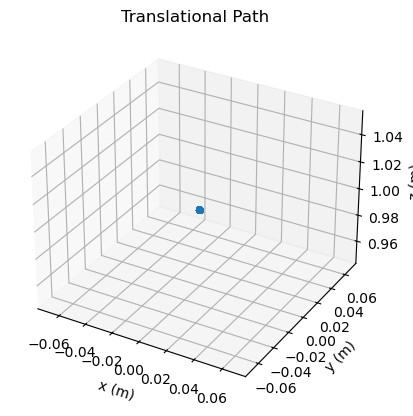

In [36]:
fig = plt.figure()
pax = fig.add_subplot(111, projection='3d')

pax.scatter(sol.y[0], sol.y[1], sol.y[2])
pax.axis('equal')

pax.set_title('Translational Path')
pax.set_xlabel('x (m)')
pax.set_ylabel('y (m)')
pax.set_zlabel('z (m)')
fig.savefig(fname = 'hover_path', dpi = 1200)
plt.show()

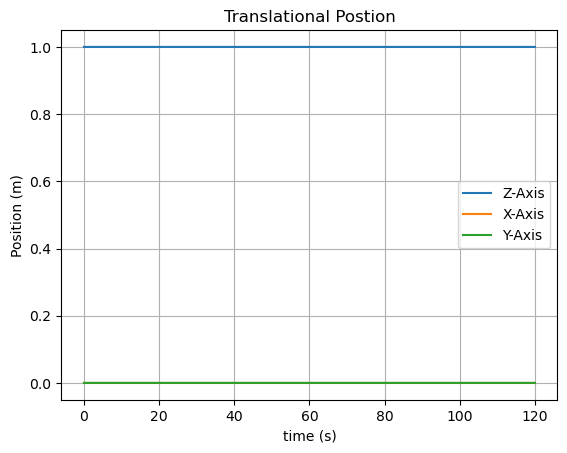

In [37]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[2], label = 'Z-Axis')
pax.plot(sol.t, sol.y[0], label = 'X-Axis')
pax.plot(sol.t, sol.y[1], label = 'Y-Axis')

pax.set_title('Translational Postion')
pax.set_xlabel('time (s)')
pax.set_ylabel('Position (m)')
pax.legend()
pax.grid()
fig.savefig(fname = 'hover_trans', dpi = 1200)
plt.show()

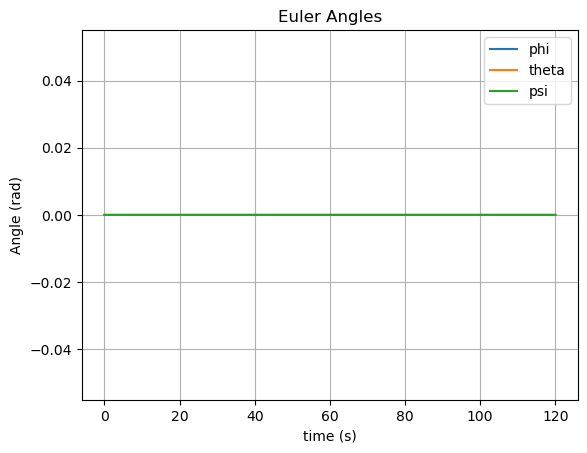

In [38]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[6], label = 'phi')
pax.plot(sol.t, sol.y[7], label = 'theta')
pax.plot(sol.t, sol.y[8], label = 'psi')

pax.set_title('Euler Angles')
pax.set_xlabel('time (s)')
pax.set_ylabel('Angle (rad)')
pax.legend()
pax.grid()
fig.savefig(fname = 'hover_euler', dpi = 1200)
plt.show()

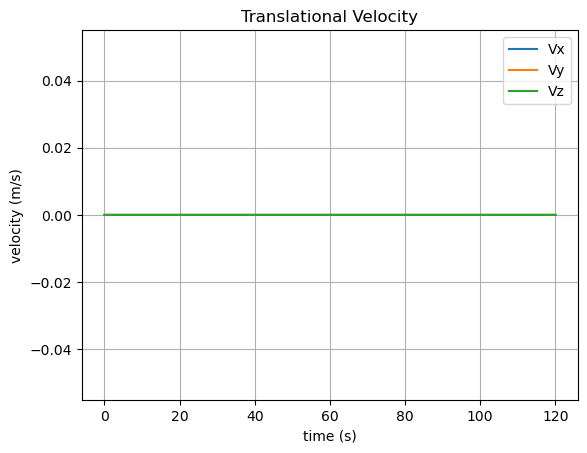

In [39]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[3], label = 'Vx')
pax.plot(sol.t, sol.y[4], label = 'Vy')
pax.plot(sol.t, sol.y[5], label = 'Vz')

pax.set_title('Translational Velocity')
pax.set_xlabel('time (s)')
pax.set_ylabel('velocity (m/s)')
pax.legend()
pax.grid()
fig.savefig(fname = 'hover_vel', dpi = 1200)
plt.show()

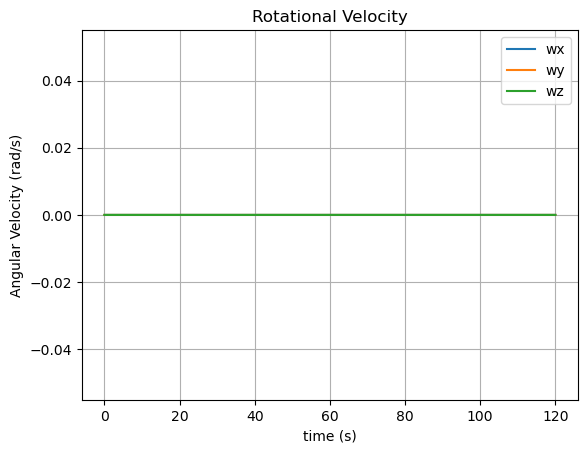

In [40]:
fig, pax = plt.subplots()
pax.plot(sol.t, sol.y[9], label = 'wx')
pax.plot(sol.t, sol.y[10], label = 'wy')
pax.plot(sol.t, sol.y[11], label = 'wz')

pax.set_title('Rotational Velocity')
pax.set_xlabel('time (s)')
pax.set_ylabel('Angular Velocity (rad/s)')
pax.legend()
pax.grid()
fig.savefig(fname = 'hover_w', dpi = 1200)
plt.show()